In [123]:
from langdetect import detect, LangDetectException
import matplotlib.pyplot as plt
import pandas as pd
import re
import joblib
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [124]:
df = pd.read_csv("Datafiniti_Hotel_Reviews_Jun19.csv", sep=',')

In [125]:
df = df.loc[:, ['reviews.rating', 'reviews.text', 'reviews.title']]
df

,reviews.rating,reviews.text,reviews.title
0,3,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel
1,4,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel
2,3,"Parking was horrible, somebody ran into my ren...",Business
3,5,Not cheap but excellent location. Price is som...,Very good
4,2,If you get the room that they advertised on th...,Low chance to come back here
...,...,...,...
9995,4,My friends and I took a trip to Hampton for th...,Very accommodating and friendly staff!
9996,5,"from check in to departure, staff is friendly,...","comfortable, friendly, clean, professional"
9997,5,This Hampton is located on a quiet street acro...,Great location
9998,5,Awesome wings (my favorite was garlic parmesan...,Great Atmosphere!


In [126]:
df = df.astype({'reviews.rating': 'int', 'reviews.title': 'str', 'reviews.text': 'str'})

In [127]:
df.loc[:, 'reviews.text'] = df.apply(lambda row: str(row['reviews.title']) + ". " + str(row['reviews.text']), axis=1)
if "reviews.title" in df.columns:
    df = df.drop("reviews.title", axis=1)

In [128]:
df

,reviews.rating,reviews.text
0,3,Best Western Plus Hotel. This hotel was nice a...
1,4,Clean rooms at solid rates in the heart of Car...
2,3,"Business. Parking was horrible, somebody ran i..."
3,5,Very good. Not cheap but excellent location. P...
4,2,Low chance to come back here. If you get the r...
...,...,...
9995,4,Very accommodating and friendly staff!. My fri...
9996,5,"comfortable, friendly, clean, professional. fr..."
9997,5,Great location. This Hampton is located on a q...
9998,5,Great Atmosphere!. Awesome wings (my favorite ...


In [129]:
df = df.dropna(subset=['reviews.rating'])
df = df.dropna(subset=['reviews.text'])
df = df.drop_duplicates()

In [130]:
df['reviews.text'] = df['reviews.text'].str.replace('[^a-zA-Z0-9 @]', '', regex=True)
df = df.dropna(subset=['reviews.text'])
df = df[df['reviews.text'] != '']

In [131]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'Unknown'
    
df['language'] = df['reviews.text'].apply(detect_language)
df

,reviews.rating,reviews.text,language
0,3,Best Western Plus Hotel This hotel was nice an...,en
1,4,Clean rooms at solid rates in the heart of Car...,en
2,3,Business Parking was horrible somebody ran int...,en
3,5,Very good Not cheap but excellent location Pri...,en
4,2,Low chance to come back here If you get the ro...,en
...,...,...,...
9995,4,Very accommodating and friendly staff My frien...,en
9996,5,comfortable friendly clean professional from c...,en
9997,5,Great location This Hampton is located on a qu...,en
9998,5,Great Atmosphere Awesome wings my favorite was...,en


In [132]:
df = df.loc[df['language'] == 'en']

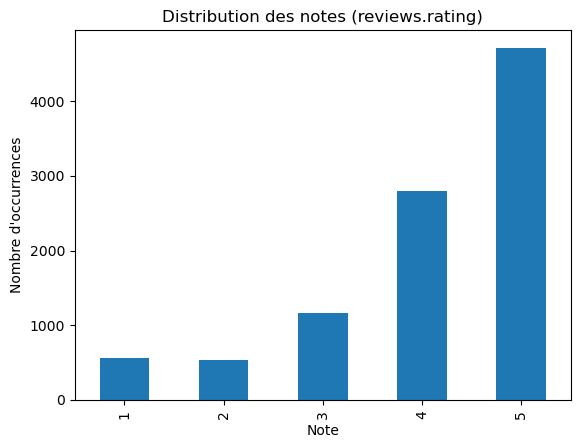

In [133]:
rating_counts = df['reviews.rating'].value_counts().sort_index()
all_ratings = pd.Series(index=range(1, 6), data=0)  # Initialiser les notes de 1 à 5 à 0
rating_counts = all_ratings.add(rating_counts, fill_value=0).astype(int)  # Ajouter les comptes existants
rating_counts.plot(kind='bar')
plt.title('Distribution des notes (reviews.rating)')
plt.xlabel('Note')
plt.ylabel('Nombre d\'occurrences')
plt.show()

In [134]:
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')  # Use English stop words
    text = [word for word in text.split() if word not in en_stopwords]
    return " ".join(text)  # Join back into a string

In [135]:
import string

def clean_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    text = remove_stopwords(text)
    return text

In [136]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(df['reviews.text']).toarray()

In [137]:
y = df['reviews.rating'].values
np.save('X_tfidf.npy', X_tfidf)
np.save('y.npy', y)

In [138]:
from nltk import WordNetLemmatizer
#nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df.loc[:, 'reviews.text'] = df['reviews.text'].apply(preprocess_text)

In [139]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['reviews.text'])
sequences = tokenizer.texts_to_sequences(df['reviews.text'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=120)

### Model TensorFlow

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [141]:
X = np.load('X_tfidf.npy')
y = np.load('y.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
regularizer = l2(0.001)
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizer),
    Dropout(0.5),
    Dense(5, activation='softmax', kernel_regularizer=regularizer)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


earlyStopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True);


y_train_adj = y_train - 1
y_test_adj = y_test - 1

In [143]:
history = model.fit(X_train, y_train_adj, epochs=100, batch_size=32, validation_split=0.2, callbacks=[earlyStopping]);

Epoch 1/100
196/196 [==============================] - 4s 17ms/step - loss: 1.4014 - accuracy: 0.5395 - val_loss: 1.1188 - val_accuracy: 0.6055
Epoch 2/100
196/196 [==============================] - 3s 15ms/step - loss: 1.0677 - accuracy: 0.6569 - val_loss: 1.0747 - val_accuracy: 0.6419
Epoch 3/100
196/196 [==============================] - 3s 17ms/step - loss: 1.0073 - accuracy: 0.6828 - val_loss: 1.0740 - val_accuracy: 0.6426
Epoch 4/100
196/196 [==============================] - 3s 13ms/step - loss: 0.9862 - accuracy: 0.6951 - val_loss: 1.0896 - val_accuracy: 0.6394
Epoch 5/100
196/196 [==============================] - 3s 13ms/step - loss: 0.9729 - accuracy: 0.7167 - val_loss: 1.1081 - val_accuracy: 0.6266
Epoch 6/100
196/196 [==============================] - 3s 14ms/step - loss: 0.9477 - accuracy: 0.7242 - val_loss: 1.1209 - val_accuracy: 0.6330
Epoch 7/100
196/196 [==============================] - 3s 16ms/step - loss: 0.9391 - accuracy: 0.7310 - val_loss: 1.1230 - val_accuracy:

In [144]:
loss, accuracy = model.evaluate(X_test, y_test_adj)
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

62/62 [==============================] - 0s 3ms/step - loss: 1.1168 - accuracy: 0.6192
Test Loss: 1.117, Test Accuracy: 0.619


In [145]:
new_review_vector = tfidf_vectorizer.transform(["Cool but the pool was cold not very cool for us"]).toarray()

In [146]:
prediction = model.predict(new_review_vector)
predicted_rating = np.argmax(prediction) + 1
print(f'Note prédite: {predicted_rating}')

1/1 [==============================] - 0s 57ms/step
Note prédite: 4


### Model Random Forest Classifier


In [147]:
# Charger les données
X = np.load('X_tfidf.npy')
y = np.load('y.npy')

In [148]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
# Initialiser le modèle RandomForest
modelRFC = RandomForestClassifier(n_estimators=100, random_state=42)

In [150]:
# Entraîner le modèle
modelRFC.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [151]:
# Prédire les étiquettes sur l'ensemble de test
y_pred = modelRFC.predict(X_test)

# Afficher le rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           1       0.72      0.25      0.37       118
           2       0.67      0.02      0.04       105
           3       0.30      0.08      0.13       236
           4       0.43      0.29      0.35       573
           5       0.59      0.93      0.72       922

    accuracy                           0.55      1954
   macro avg       0.54      0.31      0.32      1954
weighted avg       0.52      0.55      0.48      1954


Matrice de confusion :


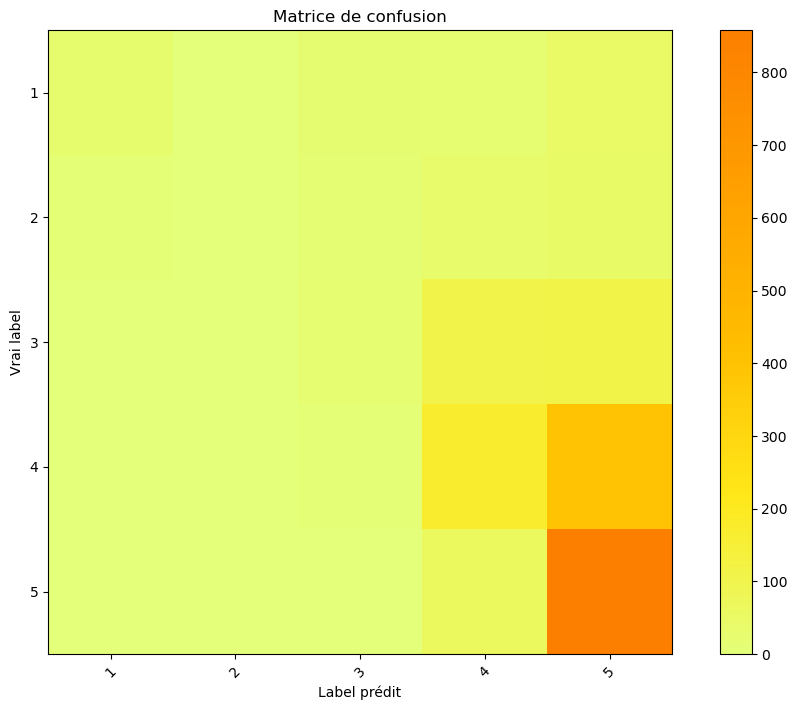

In [152]:
# Afficher la matrice de confusion
print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Matrice de confusion')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y), rotation=45)
plt.yticks(tick_marks, np.unique(y))
plt.tight_layout()
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.show()

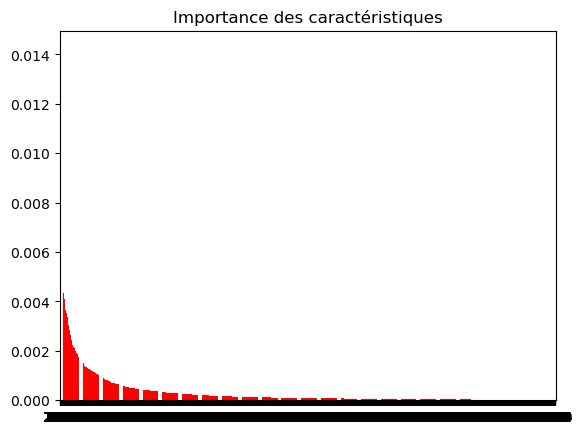

In [153]:
# Importance des caractéristiques
importances = modelRFC.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Importance des caractéristiques")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [154]:
# Ajustement des hyperparamètres avec GridSearchCV
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

Meilleurs paramètres trouvés :
{'max_depth': None, 'n_estimators': 200}


In [155]:
# Entraîner le modèle avec les meilleurs paramètres
best_model = grid_search.best_estimator_

In [156]:
# Sauvegarder le modèle
joblib.dump(best_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [157]:
# Charger le modèle
loaded_model = joblib.load('random_forest_model.joblib')

In [158]:
# Utiliser le modèle chargé pour faire des prédictions
loaded_model_pred = loaded_model.predict(X_test)
print("Rapport de classification du modèle chargé :")
print(classification_report(y_test, loaded_model_pred))

Rapport de classification du modèle chargé :
              precision    recall  f1-score   support

           1       0.79      0.32      0.46       118
           2       0.60      0.03      0.05       105
           3       0.43      0.10      0.16       236
           4       0.44      0.29      0.35       573
           5       0.59      0.93      0.72       922

    accuracy                           0.56      1954
   macro avg       0.57      0.34      0.35      1954
weighted avg       0.54      0.56      0.49      1954


In [159]:
# Charger le modèle RandomForest
modelRFC = joblib.load('random_forest_model.joblib')

In [160]:
# Nouvelle entrée d'avis
new_review = ["I hate this hotel !"]

In [161]:
# Transformer l'avis en utilisant le vectoriseur TF-IDF chargé
new_review_tfidf = tfidf_vectorizer.transform(new_review).toarray()

In [162]:
# Prédire la note pour la nouvelle entrée
predicted_note = modelRFC.predict(new_review_tfidf)

In [163]:
print("La note prédite pour l'avis est :", predicted_note[0])

La note prédite pour l'avis est : 5
